**Car Class Requirements**
- Speed relative to other cars' position
- Slowing down at turns
- Speeding up when space
- Gets to desired exit (vector-based?)

**Road Class Requirements**
- GetPosition (distance=0-1) returns location (x,y)
- GetDirection (distance=0-1) returns direction vector(dx,dy)

**Intersection Class Requirements**
- Collection of roads
- GetRoads (entry road id) return collection of roads
- Road/Path Hierarchies

**Initialisation**
- generate cars according to distribution (starting road and destination vector)
-

**TODO LIST**
- build all described classes
- create animation engine for roads and cars
- combine in simulation
- figure out car to car interractions / searching (road/intersection)

-reporting and evalutation data graphing and analysis

In [ ]:
# READ_ONLY SYNTAX NOTE: @Properties and the _underscore as read-only convention is used to create a programming
# interface to the class that differentiates between read-only and configurable parameters. ie an attribute '_param' is intented
# to be read-only outside the class and only be interfaced through its corresponding @Property def Param(self) interface if provided
import math
from matplotlib import pyplot as plt, patches
from matplotlib.patches import Rectangle
import numpy as np

#Following CLass enables retangles to be rotated around a selecte point
# https://stackoverflow.com/questions/60413174/rotating-rectangles-around-point-with-matplotlib
class RotatingRectangle(Rectangle):
    def __init__(self, xy, width, height, rel_point_of_rot, **kwargs):
        super().__init__(xy, width, height, **kwargs)
        self.rel_point_of_rot = rel_point_of_rot
        self.xy_center = self.get_xy()
        self.set_angle(self.angle)

    def _apply_rotation(self):
        angle_rad = self.angle * np.pi / 180
        m_trans = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                            [np.sin(angle_rad), np.cos(angle_rad)]])
        shift = -m_trans @ self.rel_point_of_rot
        self.set_xy(self.xy_center + shift)

    def set_angle(self, angle):
        self.angle = angle
        self._apply_rotation()

    def set_rel_point_of_rot(self, rel_point_of_rot):
        self.rel_point_of_rot = rel_point_of_rot
        self._apply_rotation()

    def set_xy_center(self, xy):
        self.xy_center = xy
        self._apply_rotation()

#Road Class
class Road:
    # Description: The Road Class is a pair of 2D parameterized
    # functions that a car travels down by modifying a displacemnt parameter 't'

    def __init__(self, index, axes, t_0, t_1, a=0, b=0, c=0, r=4.3, curve_type='circle',
                 steps=100, road_width=15, z_order=-2, has_right_of_way=False):
        self._index = index
        self._ax = axes
        self._curve_type = curve_type
        self._x_domain = 1 if t_0 < t_1 else -1
        self._road_width = road_width
        self._zorder = z_order
        self._has_right_of_way = has_right_of_way

        #initialise values of t used in drawing the road
        self.t = np.linspace(0, 1, steps)
        self._steps = steps

        #Drawing Properties
        self._a = a
        self._b = b
        self._c = c
        self._r = r
        self._t_0 = t_0
        self._t_1 = t_1

        self.Draw(self._road_width)

        self._cars=[]
        self._intersection=None

    #Read-Only Properties _________________________________________________________
    @property
    def Index(self):
        return self._index
    @property
    def CurveType(self):
        return self._curve_type
    @property
    def Start(self):
        return (self.x(0), self.y(0)) # return (x, y) coordiante of start
    @property
    def End(self):
        return (self.x(1), self.y(1)) # return (x, y) coordiante of end
    @property
    def Cars(self):
        return self._cars
    @property
    def Intersection(self):
        return self._intersection
    @property
    def HasRightOfWay(self):
        return self._has_right_of_way

    #Methods _____________________________________________________________
    def Check4CarsEnd(self):
        end = False

        for car in self._cars:
            if self._has_right_of_way:
                # test to see if the car is approaching the intersection
                if car._position + car._speed * 0.2 > 0.7:
                  end = True
                break
            else:
                # test to see if the car is entering an intersection
                if (car._speed > 0) and (car._position + car._speed * 0.2 > 1):
                    end = True
                    break
        return end

    def Check4CarsStart(self):
        start = False
        for car in self._cars:
            # test to see if the car is at the beginning of the road
            if car._position <= 0.1:
                start = True
                break
        return start

    def AddCar(self, car):
          self._cars.append(car)

    def RemoveCar(self, car):
        if car in self._cars:
          self._cars.remove(car)

    def SetIntersection(self, intersection):
        self._intersection=intersection

    def GetPosition(self, t=0): # t=0.0-1.0
        return (self.x(t), self.y(t))

    def GetDirVector(self, t=0): # t=0.0-1.0
        return (self._x_domain * self.dx(t), self.dy(t))

    def GetDirAngleDeg(self, t=0): # t=0.0-1.0
        dir_angle_rad = math.atan(self.dy(t)/self.dx(t))
        return self._rad_to_deg(dir_angle_rad)

    def GetDirAngleRad(self, t=0): # t=0.0-1.0
        dir_angle_rad = math.atan(self.dy(t)/self.dx(t))
        return dir_angle_rad

    def Draw(self, road_width=0): # Draw the road
        x = self.x(self.t)
        y = self.y(self.t)
        if road_width == 0:
            width = self._road_width
        else:
            width = road_width
        self._ax.plot(x, y, '-', linewidth=width, color='deepskyblue', alpha=0.5, zorder=self._zorder , label='road(' + str(self.Index) + ')')

        #lable exit angles
        # debug dir # self._ax.text(self.x(.25), self.y(0.25), str(round(self.GetDirAngleDeg(0), 0)), color="red", fontsize=12)

    #functions of x and y as function of t as well as 1st derrivatives
    def x(self, t):
        if self._curve_type == 'circle':
            return self._r*np.cos(self._scale_t(t))
        else: # 'parabola'
            return self._scale_t(t)

    def y(self, t):
        if self._curve_type == 'circle':
            return self._r*np.sin(self._scale_t(t))
        else: # 'parabola'
            return self._a * self._scale_t(t)**2 + self._b * self._scale_t(t) + self._c

    def dx(self, t):
        if self._curve_type == 'circle':
            return -np.sin(self._scale_t(t))
        else: # 'parabola'
            return 1

    def dy(self, t):
        if self._curve_type == 'circle':
            return np.cos(self._scale_t(t))
        else: # 'parabola'
            return self._a * 2 * self._scale_t(t) + self._b

    def _scale_t(self, t): # t=0.0-1.0
        return t * (self._t_1 - self._t_0) + self._t_0

    def _rad_to_deg(self, theta): # t=0.0-1.0
        angle = (theta / (2*np.pi)) * 360
        if self._x_domain < 0:
            return 180 + angle
        else:
            return angle


#Intersection Class
class Intersection:
    # Description: The intersection contains two collections of roads (entry roads and exit roads)
    # for any road that can be travelled in two directions there will be a duplication of this road
    # to allow for bidirectional travel. Creating a one-to-one relationship betwen road and direction
    # prevents complications in logic when assigning cars to roads, as now cars do not need to
    # differentiate beween other cars travelling on the same road but in an opposite directions.

    def __init__(self, index, axes, entry_roads, exit_roads, x, y, size=0.5, rotation_angle=0,
                 color="darkgrey", z_order=-1):
        self._index = index
        self._ax = axes
        self._entry_roads = entry_roads
        self._exit_roads = exit_roads
        self.x = x
        self.y = y
        self.Position = (self.x, self.y)
        self._angle = rotation_angle
        self._size = size
        self._zorder = z_order
        self._color = color
        self._trafficlightstate = -1 # -1=none, 0=stop, 1=go
        self.Draw(self._size)

    #Read-Only Properties _________________________________________________________
    @property
    def Index(self):
        return self._index
    @property
    def LightState(self):
        return self._light_state
    @property
    def EntryRoadsAll(self):
        return self._entry_roads
    @property
    def ExitRoadsAll(self):
        return self._exit_roads
    @property
    def TrafficLightState(self):
        return self._trafficlightstate

    #Methods _____________________________________________________________
    def GetEntryRoads(self, car_entry_road):
        entry_roads=[]
        for road in self._entry_roads:
            #exclude my road
            if road.Index != car_entry_road.Index:
                entry_roads.append(road) # add all entry roads other than one used for intersection entry
        return entry_roads

    def GetExitRoads(self, car_entry_road):
        exit_roads=[]
        for road in self._exit_roads:
            #prevent u-turns onto parallel exit-road
            if (road.Index != car_entry_road.Index) and (road.x(1), road.y(1)) != (car_entry_road.x(0), car_entry_road.y(0)):
                exit_roads.append(road) # add all exit roads other than the one parallel to the road used for intersection entry
        return exit_roads

    def Draw(self, size=0, rotation=0): # Draw the intersection
        if size == 0:
            rect_size = self._size
        else:
            rect_size = size
        point_of_rotation = np.array([rect_size/2, rect_size/2])
        rect = RotatingRectangle((self.x, self.y), width=rect_size, height=rect_size, zorder=self._zorder, angle=self._angle, color=self._color,
                        rel_point_of_rot=point_of_rotation)
        self._ax.add_patch(rect)

    def SetState(self, state):# -1=none, 0=stop, 1=go
        self._trafficlightstate = state
        if state == 0:
            self._color='firebrick'
        elif state == 1:
            self._color='forestgreen'
        else:
            self._color='darkgrey'
        self.Draw()

#Traffic Control Class
class TrafficController:
    # Description: The traffic controller manages all of the signals at Robie and Quinpool.
    # In order to simplify the routing of vehicles through the intersection joing 5 roads the
    # entry roads have each been assigned thier own 'sub' intersection. This means that the traffic
    # intersection can be approached as a set of valves that can be opened in turn in specified
    # sequence and timings.

    def __init__(self, all_intersections):

                            # duration | intersections
        self._cycle_sequence = [[20, (6, 12)], # East-West LeftTurn
                                 [40, (7, 13)], # East-West Straight/RightTurn
                                 [20, (18, 9)], # North-South LeftTurn
                                 [40, (19, 10)], # North-South Straight/RightTurn
                                 [30, (15, 16)]] # Bell Rd All
                                 # *** if you want to slow down the traffic lights ...
                                 #     ... the first number in the tupple is the number of frames for each cycle step

        self._duration_idx = 0
        self._intersections_idx = 1

        self._clock = 0
        self._cycle_num = 0
        self._lights_on = self._cycle_sequence[0][self._intersections_idx]
        self._lights_off = self._cycle_sequence[4][self._intersections_idx]

        self._all_intersections=all_intersections
        self._active_intersections=[]
        # populate active intersections
        # parse cycle for active indexes ...
        for i in range(len(self._cycle_sequence)):
            # search for both indexs
            for j in range(2):
                # get hard-coded index (above)
                idx = self._cycle_sequence[i][self._intersections_idx][j]
                # look through all intersections to find matching idx
                for k in range (len(self._all_intersections)):
                    if (self._all_intersections[k].Index == idx):
                        # initialize as off
                        all_intersections[k].State = 0 # Red/Off
                        self._active_intersections.append(all_intersections[k])

    #Read-Only Properties _________________________________________________________
    @property
    def CycleNum(self):
        return self._cycle_num
    @property
    def Clock(self):
        return self._clock
    @property
    def OnLights(self):
        return self._lights_on # [intersection, intersection]
    @property
    def OffLights(self):
        return self._lights_off # [intersection, intersection]

    #Methods _____________________________________________________________
    def GetIntersection(self, index):
        i=0
        # parse state sequence and replace indexes with intersections ...
        for i, intr in enumerate(self._active_intersections):
            if (self._active_intersections[i].Index == index):
                break
        return self._active_intersections[i]

    def Update(self):
        # update the clock
        self._clock += 1
        new_state = False
        if self._clock >= self._cycle_sequence[self._cycle_num][self._duration_idx]:
            # reset the clock
            self._clock = 0
            last_state_index = self._cycle_num
            # go to next state
            self._cycle_num += 1
            # get new state indexs
            new_state_index = self._cycle_num
            if self._cycle_num >= 5:
                self._cycle_num = 0
                new_state_index = 0

            # turn on/off the lights
            GREEN_GO = 1
            RED_STOP = 0

            turn_off_0 = self._cycle_sequence[last_state_index][self._intersections_idx][0]
            self.GetIntersection(turn_off_0).SetState(RED_STOP)
            turn_off_1 = self._cycle_sequence[last_state_index][self._intersections_idx][1]
            self.GetIntersection(turn_off_1).SetState(RED_STOP)

            turn_on_0 = self._cycle_sequence[new_state_index][self._intersections_idx][0]
            self.GetIntersection(turn_on_0).SetState(GREEN_GO)
            turn_on_1 = self._cycle_sequence[new_state_index][self._intersections_idx][1]
            self.GetIntersection(turn_on_1).SetState(GREEN_GO)


            turn_off = self._cycle_sequence[last_state_index][self._intersections_idx]
            # turn off all not-on/inactive interesections
            for i in range(len(self._active_intersections)):
                if self._active_intersections[i].Index != turn_on_0 and self._active_intersections[i].Index != turn_on_1:
                    self._active_intersections[i].SetState(RED_STOP)

def Init_Rotary_RoadAndInters(ax):

    roadwidth = 3
    #ENTRY and EXIT ROADS ________________________________________________________________________________________
    rd_1_in = Road(0, ax, 10, 3.8945, 0.0322, -0.6401, 0.1816, curve_type='parabola', road_width=roadwidth)
    rd_1_out = Road(1, ax, 3.8945, 10, 0.0322, -0.6401, 0.1816, curve_type='parabola', road_width=roadwidth)

    rd_12 = Road(2, ax, -0.4378, 0.6591, curve_type='circle', road_width=roadwidth, has_right_of_way=True)

    rd_2_in = Road(3, ax, 7.7, 3.3994, 0.2117, -0.6369, 2.352, curve_type='parabola', road_width=roadwidth)
    rd_2_out = Road(4, ax, 3.3994, 7.7, 0.2117, -0.6369, 2.352, curve_type='parabola', road_width=roadwidth)

    rd_23 = Road(5, ax, 0.6591, 1.8925, curve_type='circle', road_width=roadwidth, has_right_of_way=True)

    rd_3_in = Road(6, ax, -5.8, -1.3598, -0.0927, -1.9971, 1.5351, curve_type='parabola', road_width=roadwidth)
    rd_3_out = Road(7, ax, -1.3598, -5.8, -0.0927, -1.9971, 1.5351, curve_type='parabola', road_width=roadwidth)

    rd_34 = Road(8, ax, 1.8925, 2.9807, curve_type='circle', road_width=roadwidth, has_right_of_way=True)

    rd_4_in = Road(9, ax, -10, -4.2445, -0.0392, -0.4389, -0.4677, curve_type='parabola', road_width=roadwidth)
    rd_4_out = Road(10, ax, -4.2445, -10, -0.0392, -0.4389, -0.4677, curve_type='parabola', road_width=roadwidth)

    rd_45 = Road(11, ax, 2.9807, 4.0569, curve_type='circle', road_width=roadwidth, has_right_of_way=True)

    rd_5_in = Road(12, ax, -6, -2.6208, -0.1721, 0.4669, -1.003, curve_type='parabola', road_width=roadwidth)
    rd_5_out = Road(13, ax, -2.6208, -6, -0.1721, 0.4669, -1.003, curve_type='parabola', road_width=roadwidth)

    rd_51 = Road(14, ax, 4.0570, (2*np.pi)-0.4378, curve_type='circle', road_width=roadwidth, has_right_of_way=True)

    intersections=[]
    #INTERSECTIONS ________________________________________________________________________________________
    intr1 = Intersection(1, ax, [rd_1_in, rd_51], [rd_12, rd_1_out], rd_1_in.End[0], rd_1_in.End[1],
                         rotation_angle=rd_1_in.GetDirAngleDeg(1), size=0.75)
    intersections.append(intr1)
    intr2 = Intersection(2, ax, [rd_2_in, rd_12], [rd_23, rd_2_out], rd_2_in.End[0], rd_2_in.End[1],
                         rotation_angle=rd_2_in.GetDirAngleDeg(1), size=0.75)
    intersections.append(intr2)
    intr3 = Intersection(3, ax, [rd_3_in, rd_23], [rd_34, rd_3_out], rd_3_in.End[0], rd_3_in.End[1],
                         rotation_angle=rd_3_in.GetDirAngleDeg(1), size=0.75)
    intersections.append(intr3)
    intr4 = Intersection(4, ax, [rd_4_in, rd_34], [rd_45, rd_4_out], rd_4_in.End[0], rd_4_in.End[1],
                         rotation_angle=rd_4_in.GetDirAngleDeg(1), size=0.75)
    intersections.append(intr4)
    intr5 = Intersection(5, ax, [rd_5_in, rd_45], [rd_51, rd_5_out], rd_5_in.End[0], rd_5_in.End[1],
                         rotation_angle=rd_5_in.GetDirAngleDeg(1), size=0.75)
    intersections.append(intr5)

    #assign intersections to roads
    roads=[]
    rd_1_in.SetIntersection(intr1)
    roads.append(rd_1_in)
    roads.append(rd_1_out)
    rd_12.SetIntersection(intr2)
    roads.append(rd_12)
    rd_2_in.SetIntersection(intr2)
    roads.append(rd_2_in)
    roads.append(rd_2_out)
    rd_23.SetIntersection(intr3)
    roads.append(rd_23)
    rd_3_in.SetIntersection(intr3)
    roads.append(rd_3_in)
    roads.append(rd_3_out)
    rd_34.SetIntersection(intr4)
    roads.append(rd_34)
    rd_4_in.SetIntersection(intr4)
    roads.append(rd_4_in)
    roads.append(rd_4_out)
    rd_45.SetIntersection(intr5)
    roads.append(rd_45)
    rd_5_in.SetIntersection(intr5)
    roads.append(rd_5_in)
    roads.append(rd_5_out)
    rd_51.SetIntersection(intr1)
    roads.append(rd_51)

    return roads, intersections

def Init_QuinRobie_RoadAndInters(ax):
    roadwidth = 2
    #QUINPOOL ________________________________________________________________________________________
    rd_quinpool_in = Road(15, ax, -10, -6, 0, 0.25, -0.5, curve_type='parabola',
                          road_width=roadwidth)
    rd_quinpool_left = Road(16, ax, -6, -1.2, 0, 0.280769, -0.315385, curve_type='parabola',
                            road_width=roadwidth)
    rd_quinpool_noleft = Road(17, ax, -6, -1.1, 0.0328737, 0.410446, -0.72078, curve_type='parabola',
                              road_width=roadwidth)
    rd_quinpool_out = Road(18, ax, -1.5, -10, 0, 0.286316, 0.363158, curve_type='parabola',
                           road_width=roadwidth)

    #ROBIE SOUTH ________________________________________________________________________________________
    rd_robiesouth_in = Road(19, ax, -2.84, -1.63, 0, -4.099175, -1.68165, curve_type='parabola',
                          road_width=roadwidth)
    rd_robiesouth_left = Road(20, ax, -1.63, -0.32, -1.3612, -5.44658, -0.251345, curve_type='parabola',
                            road_width=roadwidth)
    rd_robiesouth_noleft = Road(21, ax, -1.63, -0.8, 0, -4.52222, -2.37122, curve_type='parabola',
                              road_width=roadwidth)
    rd_robiesouth_out = Road(22, ax, 0.32, -1.74, 0, -4.04867, 2.95531, curve_type='parabola',
                           road_width=roadwidth)

    #COGSWELL ________________________________________________________________________________________
    rd_cogswell_in = Road(23, ax, 9.98, 4.88, 0.0223506, 0.285517, 0.574411, curve_type='parabola',
                          road_width=roadwidth)
    rd_cogswell_left = Road(24, ax, 4.86, 1.6, 0.0539047, 0.314062, -0.259551, curve_type='parabola',
                            road_width=roadwidth)
    rd_cogswell_noleft = Road(25, ax, 4.88, 1.45, 0, 0.470443, 0.204236, curve_type='parabola',
                              road_width=roadwidth)
    rd_cogswell_out = Road(26, ax, 1.74, 10, 0.0204647, 0.328515, -0.831625, curve_type='parabola',
                           road_width=roadwidth)
    #BELL ROAD ________________________________________________________________________________________
    rd_bell_in = Road(27, ax, 10, 5.09, -0.00698199, -0.186502, -0.279814, curve_type='parabola',
                          road_width=roadwidth)
    rd_bell_left = Road(28, ax, 5.085, 1.94, 0.0338959, -0.451155, 0.0176703, curve_type='parabola',
                            road_width=roadwidth)
    rd_bell_noleft = Road(29, ax, 5.085, 1.956, 0.000368471, -0.306206, 0.147529, curve_type='parabola',
                              road_width=roadwidth)
    rd_bell_out = Road(30, ax, 1.9, 10, 0, -0.260285, -0.692351, curve_type='parabola',
                           road_width=roadwidth)

    #ROBIE NORTH ________________________________________________________________________________________
    rd_robienorth_in = Road(31, ax, 3.33, 2, 0, -4.4812, 4.96241, curve_type='parabola',
                          road_width=roadwidth)
    rd_robienorth_left = Road(32, ax, 2, 0.93, 2.30018, -9.3189, 5.43722, curve_type='parabola',
                            road_width=roadwidth)
    rd_robienorth_noleft = Road(33, ax, 2, 1.31, 0, -4.15493, 4.30986, curve_type='parabola',
                              road_width=roadwidth)
    rd_robienorth_out = Road(34, ax, 0.17, 2.27, 0, -3.96226, -0.90566, curve_type='parabola',
                           road_width=roadwidth)

    intersections=[]
    #QUINPOOL ________________________________________________________________________________________
    intr_quin_left = Intersection(6, ax, [rd_quinpool_left],
                                     [rd_robiesouth_out],
                                  rd_quinpool_left.End[0], rd_quinpool_left.End[1],
                                    rotation_angle=rd_quinpool_left.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_quin_left)
    intr_quin_noleft = Intersection(7, ax, [rd_quinpool_noleft],
                                     [rd_cogswell_out, rd_bell_out, rd_robienorth_out],
                                    rd_quinpool_noleft.End[0], rd_quinpool_noleft.End[1],
                                    rotation_angle=rd_quinpool_noleft.GetDirAngleDeg(1), size=0.5)

    intersections.append(intr_quin_noleft)
    intr_quin_in_left = Intersection(8, ax, [rd_quinpool_in],
                                     [rd_quinpool_left, rd_quinpool_noleft],
                                     rd_quinpool_in.End[0], rd_quinpool_in.End[1],
                                    rotation_angle=rd_quinpool_in.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_quin_in_left)
    #ROBIE SOUTH ________________________________________________________________________________________
    intr_robiesouth_left = Intersection(9, ax, [rd_robiesouth_left],
                                     [rd_cogswell_out, rd_bell_out],
                                    rd_robiesouth_left.End[0], rd_robiesouth_left.End[1],
                                    rotation_angle=rd_robiesouth_left.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_robiesouth_left)
    intr_robiesouth_noleft = Intersection(10, ax, [rd_robiesouth_left],
                                     [rd_robienorth_out, rd_quinpool_out],
                                          rd_robiesouth_noleft.End[0], rd_robiesouth_noleft.End[1],
                                    rotation_angle=rd_robiesouth_noleft.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_robiesouth_noleft)
    intr_robiesouth_in_left = Intersection(11, ax, [rd_robiesouth_in],
                                     [rd_robiesouth_left, rd_robiesouth_noleft],
                                           rd_robiesouth_in.End[0], rd_robiesouth_in.End[1],
                                    rotation_angle=rd_robiesouth_in.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_robiesouth_in_left)
    #COGSWELL ________________________________________________________________________________________
    intr_cogswell_left = Intersection(12, ax, [rd_cogswell_left],
                                     [rd_robienorth_out],
                                      rd_cogswell_left.End[0], rd_cogswell_left.End[1],
                                    rotation_angle=rd_cogswell_left.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_cogswell_left)
    intr_cogswell_noleft = Intersection(13, ax, [rd_cogswell_left],
                                     [rd_robiesouth_out, rd_quinpool_out],
                                        rd_cogswell_noleft.End[0], rd_cogswell_noleft.End[1],
                                    rotation_angle=rd_cogswell_noleft.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_cogswell_noleft)
    intr_cogswell_in_left = Intersection(14, ax, [rd_cogswell_in],
                                     [rd_cogswell_left, rd_cogswell_noleft],
                                         rd_cogswell_in.End[0], rd_cogswell_in.End[1],
                                    rotation_angle=rd_cogswell_in.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_cogswell_in_left)

    #BELL ROAD ________________________________________________________________________________________
    intr_bell_left = Intersection(15, ax, [rd_bell_left],
                                     [rd_robienorth_out, rd_quinpool_out],
                                  rd_bell_left.End[0], rd_bell_left.End[1],
                                    rotation_angle=rd_bell_left.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_bell_left)
    intr_bell_noleft = Intersection(16, ax, [rd_bell_left],
                                     [rd_robiesouth_out, rd_quinpool_out],
                                    rd_bell_noleft.End[0], rd_bell_noleft.End[1],
                                    rotation_angle=rd_bell_noleft.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_bell_noleft)
    intr_bell_in_left = Intersection(17, ax, [rd_bell_in],
                                     [rd_bell_left, rd_bell_noleft],
                                     rd_bell_in.End[0], rd_bell_in.End[1],
                                    rotation_angle=rd_bell_in.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_bell_in_left)
    #ROBIE NORTH ________________________________________________________________________________________
    intr_robienorth_left = Intersection(18, ax, [rd_robienorth_left],
                                     [rd_quinpool_out], rd_robienorth_left.End[0],
                                        rd_robienorth_left.End[1],
                                    rotation_angle=rd_robienorth_left.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_robienorth_left)
    intr_robienorth_noleft = Intersection(19, ax, [rd_robienorth_left],
                                     [rd_bell_out, rd_cogswell_out, rd_robiesouth_out],
                                          rd_robienorth_noleft.End[0], rd_robienorth_noleft.End[1],
                                    rotation_angle=rd_robienorth_noleft.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_robienorth_noleft)
    intr_robienorth_in_left = Intersection(20, ax, [rd_robienorth_in],
                                     [rd_robienorth_left, rd_robienorth_noleft],
                                           rd_robienorth_in.End[0], rd_robienorth_in.End[1],
                                    rotation_angle=rd_robienorth_in.GetDirAngleDeg(1), size=0.5)
    intersections.append(intr_robienorth_in_left)
    #BG ________________________________________________________________________________________
    intr_bg = Intersection(21, ax, [], [], 0.11, 0,
                                    rotation_angle=rd_robiesouth_left.GetDirAngleDeg(1), size=3.0, z_order=-4, color='grey')
    #assign intersections to roads
    roads=[]
    #QUINPOOL ________________________________________________________________________________________
    rd_quinpool_in.SetIntersection(intr_quin_in_left)
    roads.append(rd_quinpool_in)
    rd_quinpool_left.SetIntersection(intr_quin_left)
    roads.append(rd_quinpool_left)
    rd_quinpool_noleft.SetIntersection(intr_quin_noleft)
    roads.append(rd_quinpool_noleft)
    roads.append(rd_quinpool_out)
    #ROBIE SOUTH ________________________________________________________________________________________
    rd_robiesouth_in.SetIntersection(intr_robiesouth_in_left)
    roads.append(rd_robiesouth_in)
    rd_robiesouth_left.SetIntersection(intr_robiesouth_left)
    roads.append(rd_robiesouth_left)
    rd_robiesouth_noleft.SetIntersection(intr_robiesouth_noleft)
    roads.append(rd_robiesouth_noleft)
    roads.append(rd_robiesouth_out)
    #COGSWELL ________________________________________________________________________________________
    rd_cogswell_in.SetIntersection(intr_cogswell_in_left)
    roads.append(rd_cogswell_in)
    rd_cogswell_left.SetIntersection(intr_cogswell_left)
    roads.append(rd_cogswell_left)
    rd_cogswell_noleft.SetIntersection(intr_cogswell_noleft)
    roads.append(rd_cogswell_noleft)
    roads.append(rd_cogswell_out)
    #BELL ROAD ________________________________________________________________________________________
    rd_bell_in.SetIntersection(intr_bell_in_left)
    roads.append(rd_bell_in)
    rd_bell_left.SetIntersection(intr_bell_left)
    roads.append(rd_bell_left)
    rd_bell_noleft.SetIntersection(intr_bell_noleft)
    roads.append(rd_bell_noleft)
    roads.append(rd_bell_out)
    #ROBIE NORTH ________________________________________________________________________________________
    rd_robienorth_in.SetIntersection(intr_robienorth_in_left)
    roads.append(rd_robienorth_in)
    rd_robienorth_left.SetIntersection(intr_robienorth_left)
    roads.append(rd_robienorth_left)
    rd_robienorth_noleft.SetIntersection(intr_robienorth_noleft)
    roads.append(rd_robienorth_noleft)
    roads.append(rd_robienorth_out)

    return roads, intersections



In [ ]:
import numpy as np

class Car:
    def __init__(self, entry_time, traffic, road, speed, ax, direction, length=0.4, width=0.2, color='b'):
        """
        Initializes a Car object.

        Parameters:
            entry_time (float): The time at which the car enters the system.
            traffic (TrafficController): An instance of the TrafficController class.
            road (Road): The road on which the car travels initially.
            speed (float): The initial speed of the car.
            ax (object): The matplotlib axis object for plotting.
            direction (float): The direction in which the car is heading.
            length (float, optional): The length of the car. Defaults to 0.4.
            width (float, optional): The width of the car. Defaults to 0.2.
            color (str, optional): The color of the car. Defaults to blue.
        """

        self._entry_time = entry_time
        self._traffic = traffic
        self._road = road
        self._speed = speed
        self._ax = ax
        self._direction = direction
        self._length = length
        self._width = width
        self._color = color
        self._shape = np.array([[0, length, length, 0, 0], [-width/2, -width/2, width/2, width/2, -width/2]])
        self._obj = ax.plot([], [], color)[0]
        self._travel_time = 0
        self._position = 0


    def draw(self):
        """
        Draws the car on the plot.
        """

        x = self._road.x(0)
        y = self._road.y(0)
        self.check_other_cars()
        self._obj.set_data(x, y)


    def move(self):
        """
        Moves the car forward.
        """

        # check for other cars before you move
        self.check_other_cars()
        self._position += self._speed * 0.2


    def decide_road(self):
        """
        Decides which road to take next based on the car's direction.

        Returns:
          chosen_road_exit: the next road to take.
        """

        exit_roads = self._road._intersection.GetExitRoads(self._road)
        min_diff = np.inf
        chosen_road_exit = None
        # check a list of exit roads connected to current intersection
        for r in exit_roads:
            temp_diff = abs(r.GetDirAngleDeg(0) - self._direction)
            # find the road that brings car closest to desired directionn
            if temp_diff < min_diff:
                min_diff = temp_diff
                chosen_road_exit = r
        return chosen_road_exit


    def check_other_cars(self):
        """
        Checks for nearby cars and adjusts speed accordingly.
        """

        # if the car is breaking, try to increase speed
        if self._speed == 0:
            self._speed = 0.1
        # if speed is less than 0.3, car can accelerate
        if self._speed <= 0.3:
            self._speed += (0.01 * self._speed)
        # look at surrounding cars
        for car in self._road._cars:
            # if a car is too close, break
            if car != self and car._position > self._position and car._position - self._position <= 0.2:
                self._speed = 0
            # if a car is starting to get close, slow down
            elif car != self and car._position > self._position and car._position - self._position <= 1:
                self._speed = min(abs(car._position - self._position) / 2, self._speed)


    def update_position(self, frame):
        """
        Updates the position of the car.

        Parameters:
            frame: Frame number for animation.
        """

        # if we are not on an exit road yet, track travel time
        if self._road._index not in [18, 22, 26, 30, 34]:
          self._travel_time += 1

        # if car reached an intersection, decide what to do next
        if self._position >= 0.9 and self._road._intersection is not None:
            # if red light, stop moving
            if self._road._intersection._trafficlightstate == 0:
                self._speed = 0
                return
            # otherwise, look at which road to take next, and when to go there
            else:
                entry_roads = self._road._intersection.GetEntryRoads(self._road)
                check_end = False
                for r in entry_roads:
                    if r.Check4CarsEnd():
                        check_end = True
                        break
                chosen_road_exit = self.decide_road()
                # only go into the road if there are no cars blocking your way
                if chosen_road_exit.Check4CarsStart() == False and check_end == False:
                    # remove car from old road an add to new road
                    self._road.RemoveCar(self)
                    self._road = chosen_road_exit
                    self._road.AddCar(self)
                    self._position = 0
                    self.move()
                elif chosen_road_exit.Check4CarsStart() == True or check_end == True:
                    return
        # if no intersection encountered, move normally
        else:
            self.move()
        # update car's coordinates
        x, y = self._road.GetPosition(self._position)
        # rotate car if needed
        theta = self._road.GetDirAngleRad(self._position)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_shape = np.dot(rotation_matrix, self._shape)
        # update car's position on the plot
        self._obj.set_data(rotated_shape[0] + x, rotated_shape[1] + y)


    def update_position_roundabout(self, frame):
        """
        Updates the position of the car in a roundabout scenario.

        Parameters:
            frame: Frame number for animation.
        """

        # if we are not on an exit road yet, track travel time
        if self._road._index not in [1, 4, 7, 10, 13]:
          self._travel_time += 1

        # if car reached an intersection, decide what to do next
        if self._position >= 0.8 and self._road._intersection is not None:
            # look at which road to take next, and when to go there
            entry_roads = self._road._intersection.GetEntryRoads(self._road)
            check_end = False
            for r in entry_roads:
                if r.Check4CarsEnd():
                    check_end = True
                    break
            chosen_road_exit = self.decide_road()
            # only go into the road if there are no cars blocking your way and you have the right of way
            if (chosen_road_exit.Check4CarsStart() == False and check_end == False) or self._road._has_right_of_way:
                self._road.RemoveCar(self)
                self._road = chosen_road_exit
                self._road.AddCar(self)
                self._position = 0
                self.move()
            elif chosen_road_exit.Check4CarsStart() == True or check_end == True:
                return
        # if no intersection encountered, move normally
        else:
            self.move()
        # update car's coordinates
        x, y = self._road.GetPosition(self._position)
        # rotate car if needed
        theta = self._road.GetDirAngleRad(self._position)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_shape = np.dot(rotation_matrix, self._shape)
        # update car's position on the plot
        self._obj.set_data(rotated_shape[0] + x, rotated_shape[1] + y)

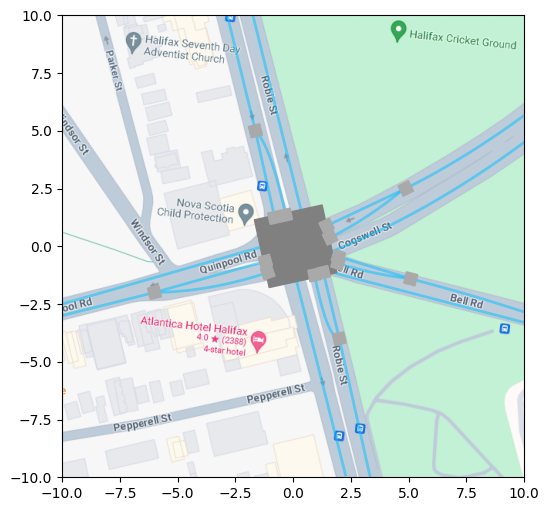

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import HTML
from PIL import Image
from numpy import asarray

# number of frames of animation
frames = np.linspace(0, 1, 1000)

# default traffic condition is 50%
traffic_condition = 0.5

# show image of intersection
plt.show()

# Define the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# init patch
patch = plt.Circle((5, -5), 0.75, fc='y')

# setup background image and plot
img2 = plt.imread("robie_quinpool1.png")
ax.imshow(img2, extent=[-10, 10, -10, 10], zorder=-5)

# # import roads and intersections
roads, intersections = Init_QuinRobie_RoadAndInters(ax)
# import traffic lights
traffic_controller = TrafficController(intersections)
traffic_controller.Update()

# create a list to store references to the plotted objects
cars = []
traffic_lights = []
number_of_lights = len(intersections)

# traffic flow (should be a float within [0, 1]) determine number of cars
# number of cars can be no bigger than 0.4 * number of frames
number_of_cars = int(traffic_condition*0.4*len(frames))

# index of starting roads and their respective car colors
starting_road_indices = [0, 4, 8, 12, 16]
corresponding_colors = ['b', 'k', 'c', 'y', 'm']

# create initial plots for each object
for i in range(number_of_cars):
    picked = np.random.randint(0, 5)
    # pick a road
    road_number = starting_road_indices[picked]
    # create car
    new_car = Car(entry_time = np.random.rand(), road=roads[road_number], ax=ax, speed=0.1, direction=0,
                                    traffic=traffic_controller, color=corresponding_colors[picked])
    # add car to road
    roads[road_number].AddCar(new_car)
    new_car.index = len(roads[road_number]._cars) - 1
    cars.append(new_car)

# create initial plots for each object
for i in range(number_of_lights):
    obj = ax.plot([], [], 'g-')[0]
    traffic_lights.append(obj)

def init():
    """
    Initializes the animation.

    Returns:
        list: List of car objects for animation.
    """

    # need to do this three times for traffic lights to have a color on time
    for i in range(3):
      traffic_controller.Update()

    # initialize cars
    car_obj_array = []
    for i, c in enumerate(cars):
        c.draw()
        car_obj_array.append(c._obj)

    # drawing traffic controllers
    patch.center = (5, 5)
    ax.add_patch(patch)

    return car_obj_array


def update(frame):
    """
    Updates each car's position in the animation.

    Parameters:
        frame: Frame number for animation.

    Returns:
        list: List of car objects for animation.
    """

    # update traffic controller state
    traffic_controller.Update()

    # update cars
    car_obj_array = []
    for idx, c in enumerate(cars):
        if frame >= c._entry_time : c.update_position(frame)
        car_obj_array.append(c._obj)

    return car_obj_array

In [ ]:
# create a default animation
ani = animation.FuncAnimation(fig, update, init_func=init, frames=frames, blit=True, interval=100)
HTML(ani.to_html5_video())

<ipython-input-193-55af78d3949d>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)
<ipython-input-193-55af78d3949d>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


HTML(value='<video width="600" height="600" controls autoplay loop>\n  <source type="video/mp4" src="data:vide…

In [ ]:
def traffic_stop_simulation(traffic_condition, skewed=False, skewness=None, multidirection=False):
  """
  Simulates car traffic without animating it.
  Addition: Assymetric probability of cars entering from some roads over others.
  More specifically, two out of the five entry roads have a higher probability of cars
  spawning in them than the other roads.
  Addition to addition: now running with each car heading a random direction,
  instead of a predetermined one.

  Parameters:
    traffic_condition: Traffic flow condition (should be a float within [0, 1]),
                       0 means no traffic, 1 means maximally busy.
    skewness: a float within [0, 1] that represents the combined spawn probability of the
    two higher-spawn probability roads.
  Returns:
    cars: an array of car objects and information on their final configurations.
    high_traffic_cars: an array of cars which ended up starting in the two heavier-traffic roads.
    low_traffic_cars: an array of cars which ended up starting in the lighter-traffic roads (all the other roads).
  """

  # number of frames of animation
  frames = np.linspace(0, 1, 1000)

  # import roads and intersections
  roads, intersections = Init_QuinRobie_RoadAndInters(ax)
  # import traffic lights
  traffic_controller = TrafficController(intersections)
  traffic_controller.Update()

  # create a list to store references to the plotted objects
  cars = []
  heavy = []
  light = []
  traffic_lights = []
  number_of_lights = len(intersections)

  # traffic condition (should be a float within [0, 1]) determine number of cars
  # number of cars can be no bigger than 0.4 * number of frames
  number_of_cars = int(traffic_condition*0.4*len(frames))

  # index of starting roads and their respective car colors
  starting_road_indices = [0, 4, 8, 12, 16]
  corresponding_colors = ['b', 'k', 'c', 'y', 'm']

  # create initial plots for each object
  for i in range(number_of_cars):

      # apply skewed traffic distribution if desired
      if skewed == True:
        high_p = skewness/2
        low_p = (1 - skewness)/3
        if low_p*3 != 1-skewness:
          low_p -= ((low_p*3) - (1-skewness))/3
        # define starting road weights, higher weight for two of the five roads
        weights = [high_p, low_p, low_p, high_p, low_p]
        # generate a random road choice with bias
        picked = np.random.choice([0, 1, 2, 3, 4], 1, p=weights)[0]
      else:
        # generate random road choice otherwise
        picked = np.random.randint(0, 5)

      # pick a road
      road_number = starting_road_indices[picked]

      # apply random direction destinations if desired
      if multidirection == True:
        # create car with random destination direction
        new_car = Car(entry_time = np.random.rand(), road=roads[road_number], ax=ax, speed=0.1, direction=np.random.randint(0, 360),
                                traffic=traffic_controller, color=corresponding_colors[picked])
      else:
        # create car that goes straight ahead
        new_car = Car(entry_time = np.random.rand(), road=roads[road_number], ax=ax, speed=0.1, direction=0,
                                        traffic=traffic_controller, color=corresponding_colors[picked])

      # sort cars into heavy and light traffic if skewness is toggled on
      if skewed == True:
        if road_number in [0, 12]:
          heavy.append(new_car)
        else:
          light.append(new_car)

      # add car to road
      roads[road_number].AddCar(new_car)
      new_car.index = len(roads[road_number]._cars) - 1
      cars.append(new_car)

  # need to do this for traffic lights to work
  for i in range(3):
    traffic_controller.Update()

  # initialize cars
  car_obj_array = []
  for i, c in enumerate(cars):
      c.draw()

  # perform the simulation
  for frame in frames:
    for c in cars:
      if frame >= c._entry_time :
        # if we are not on an exit road yet, track travel time
        if c._road._index not in [18, 22, 26, 30, 34]:
          c._travel_time += 1
        # if car reached an intersection, decide what to do next
        if c._position >= 1 and c._road._intersection is not None:
            # if red light, stop moving
            if c._road._intersection._trafficlightstate == 0:
                c._speed = 0
            # otherwise, look at which road to take next, and when to go there
            else:
                entry_roads = c._road._intersection.GetEntryRoads(c._road)
                check_end = False
                for r in entry_roads:
                    if r.Check4CarsEnd():
                        check_end = True
                        break
                chosen_road_exit = c.decide_road()
                # only go into the road if there are no cars blocking your way
                if chosen_road_exit.Check4CarsStart() == False and check_end == False:
                    # remove car from old road an add to new road
                    c._road.RemoveCar(c)
                    c._road = chosen_road_exit
                    c._road.AddCar(c)
                    c._position = 0
                    c.move()
                elif chosen_road_exit.Check4CarsStart() == True or check_end == True:
                    continue
        # if no intersection encountered, move normally
        else:
            c.move()
        # update car's coordinates
        x, y = c._road.GetPosition(c._position)
        # rotate car if needed
        theta = c._road.GetDirAngleRad(c._position)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_shape = np.dot(rotation_matrix, c._shape)

  if skewed == True:
    return cars, heavy, light
  else:
    return cars

In [ ]:
# data collection
import numpy as np
import matplotlib.pyplot as plt

# task 1: collect the average waiting/travel time of each car
# perform simulation with 50% traffic flow
cars = traffic_stop_simulation(0.5)

# find average travel time
travel_times = []
for c in cars:
  travel_times.append(c._travel_time)
print("The average time for a car to pass the intersection is: {0} frames".format(np.mean(travel_times)))

<ipython-input-193-55af78d3949d>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


The average time for a car to pass the intersection is: 120.275 frames


<ipython-input-3-0bd98dceaa9e>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


Text(0, 0.5, 'Average travel time of cars')

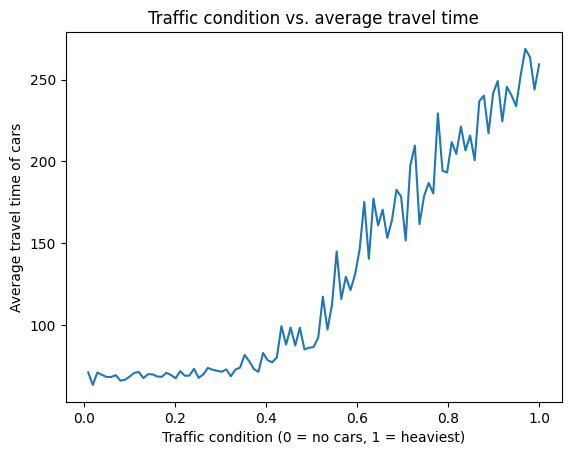

In [ ]:
# task 2: plotting average travel time vs. traffic flow
traffic_flow_range = np.linspace(0, 1, 100)
travel_time_averages = []
for tf in traffic_flow_range:
  # perform simulation
  cars = traffic_stop_simulation(tf)
  # obtain average travel time
  travel_times = []
  for c in cars:
    travel_times.append(c._travel_time)
  travel_time_averages.append(np.mean(travel_times))
# plotting
plt.plot(traffic_flow_range, travel_time_averages)
plt.title("Traffic condition vs. average travel time")
plt.xlabel("Traffic condition (0 = no cars, 1 = heaviest)")
plt.ylabel("Average travel time of cars")

In [ ]:
# task 3: implementing assymetric traffic and calculating average travel time for
# heavy and light traffic roads separately
cars, heavy, light = traffic_stop_simulation(0.5, skewed=True, skewness=0.7)

# find average travel time for heavy traffic cars
travel_times_heavy = []
for c in heavy:
  travel_times_heavy.append(c._travel_time)
print("The average time for a car to pass the intersection when coming from a heavier-traffic road is: {0} frames".format(np.mean(travel_times_heavy)))

# find average travel time for light traffic cars
travel_times_light = []
for c in light:
  travel_times_light.append(c._travel_time)
print("The average time for a car to pass the intersection when coming from a lighter-traffic road is: {0} frames".format(np.mean(travel_times_light)))

<ipython-input-3-0bd98dceaa9e>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


The average time for a car to pass the intersection when coming from a heavier-traffic road is: 107.65 frames
The average time for a car to pass the intersection when coming from a lighter-traffic road is: 87.4 frames


<ipython-input-3-0bd98dceaa9e>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


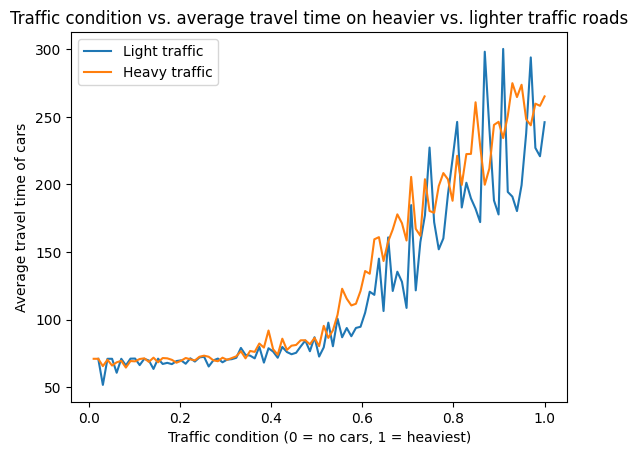

In [ ]:
# task 4: implementing assymetric traffic and calculating average travel time vs.
# traffic conditions for light and heavy traffic cars separately
traffic_flow_range = np.linspace(0, 1, 100)

# store heavy and light traffic averages separately
travel_time_averages_heavy = []
travel_time_averages_light = []
for tf in traffic_flow_range:
  # perform simulation
  cars, heavy, light = traffic_stop_simulation(tf, skewed=True, skewness=0.7)
  # obtain average travel time for heavy traffic
  travel_times = []
  for c_h in heavy:
    travel_times.append(c_h._travel_time)
  travel_time_averages_heavy.append(np.mean(travel_times))
  # obtain average travel time for light traffic
  travel_times = []
  for c_l in light:
    travel_times.append(c_l._travel_time)
  travel_time_averages_light.append(np.mean(travel_times))

# plotting heavy traffic averages
plt.figure()
plt.plot(traffic_flow_range, travel_time_averages_light, label="Light traffic")
plt.plot(traffic_flow_range, travel_time_averages_heavy, label="Heavy traffic")
plt.title("Traffic condition vs. average travel time on heavier vs. lighter traffic roads")
plt.xlabel("Traffic condition (0 = no cars, 1 = heaviest)")
plt.ylabel("Average travel time of cars")
plt.legend()

<ipython-input-193-55af78d3949d>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


Text(0, 0.5, 'Average travel time of cars')

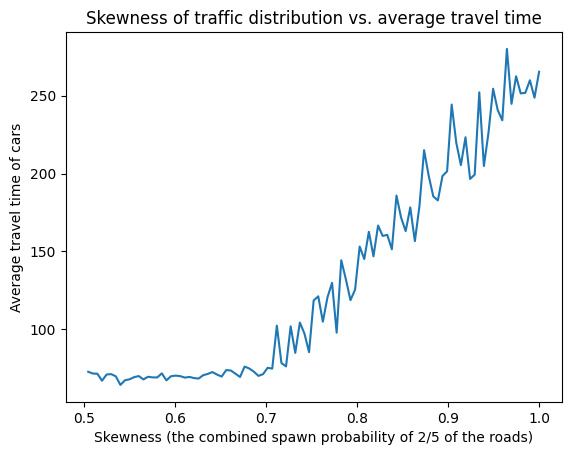

In [ ]:
# task 5: keeping the traffic condition fixed and increasing skewness to see how
# it affects the overall average travel time

skewness_range = np.linspace(0.5, 1, 100)

travel_time_averages_skew = []
for sk in skewness_range:
  # perform simulation
  cars, heavy, light = traffic_stop_simulation(0.5, skewed=True, skewness=sk)
  # obtain average travel time
  travel_times = []
  for c in cars:
    travel_times.append(c._travel_time)
  travel_time_averages_skew.append(np.mean(travel_times))

# plotting heavy traffic averages
plt.figure()
plt.plot(skewness_range, travel_time_averages)
plt.title("Skewness of traffic distribution vs. average travel time")
plt.xlabel("Skewness (the combined spawn probability of 2/5 of the roads)")
plt.ylabel("Average travel time of cars")

<ipython-input-3-0bd98dceaa9e>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


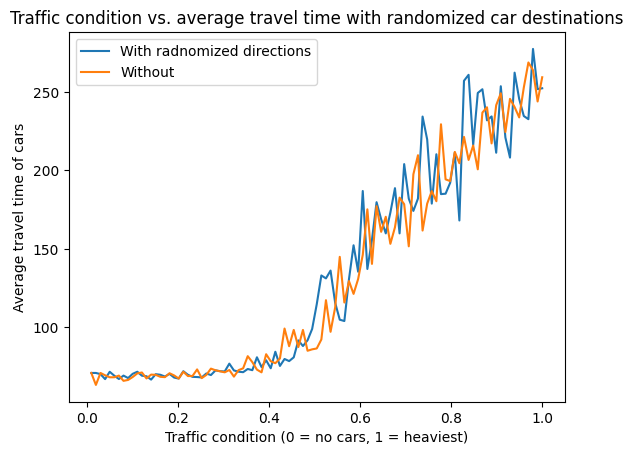

In [ ]:
# task 6: investigating average travel time vs. traffic condition for
# a randomized-destination simulation
traffic_flow_range = np.linspace(0, 1, 100)
travel_time_averages_multi = []
for tf in traffic_flow_range:
  # perform simulation
  cars = traffic_stop_simulation(tf, multidirection=True)
  # obtain average travel time
  travel_times = []
  for c in cars:
    travel_times.append(c._travel_time)
  travel_time_averages_multi.append(np.mean(travel_times))
# plotting
plt.plot(traffic_flow_range, travel_time_averages_multi, label="With radnomized directions")
plt.plot(traffic_flow_range, travel_time_averages, label="Without")
plt.title("Traffic condition vs. average travel time with randomized car destinations")
plt.xlabel("Traffic condition (0 = no cars, 1 = heaviest)")
plt.ylabel("Average travel time of cars")
plt.legend()

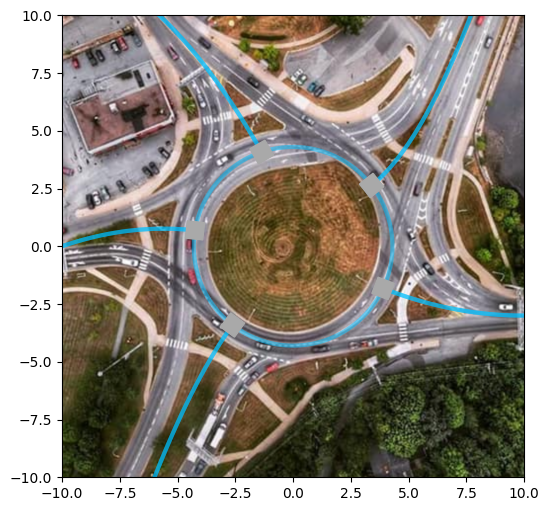

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import HTML
from PIL import Image
from numpy import asarray

# number of frames of animation
frames = np.linspace(0, 1, 1000)

# default traffic condition is 50%
traffic_condition = 0.5

# show image of intersection
plt.show()

# Define the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# init patch
patch = plt.Circle((5, -5), 0.75, fc='y')

#setup bg image and plot
img1 = plt.imread("aerial_rotary.png")
ax.imshow(img1, extent=[-10, 10, -10, 10], zorder=-5)

# import roads and intersections
roads, intersections = Init_Rotary_RoadAndInters(ax)

# Create a list to store references to the plotted objects
cars = []

# traffic flow (should be a float within [0, 1]) determine number of cars
# number of cars can be no bigger than 0.4 * number of frames
number_of_cars = int(traffic_condition*0.4*len(frames))

# index of starting roads and their respective car colors
starting_road_indices = [0, 3, 6, 9, 12]
corresponding_colors = ['b', 'k', 'c', 'y', 'm']

# create initial plots for each object
for i in range(number_of_cars):
    picked = np.random.randint(0, 5)
    # pick a road
    road_number = starting_road_indices[picked]
    # create car
    new_car = Car(entry_time = np.random.rand(), road=roads[road_number], ax=ax, speed=0.1, direction=0,
                                    traffic=traffic_controller, color=corresponding_colors[picked])
    # add car to road
    roads[road_number].AddCar(new_car)
    new_car._index = len(roads[road_number]._cars) - 1
    cars.append(new_car)

def init_r():
    """
    Initializes the animation.

    Returns:
        list: List of car objects for animation.
    """

    # initialize cars
    car_obj_array = []
    for i, c in enumerate(cars):
        c.draw()
        car_obj_array.append(c._obj)

    # drawing traffic controllers
    patch.center = (5, 5)
    ax.add_patch(patch)

    return car_obj_array

def update_r(frame):
    """
    Updates each car's position in the animation.

    Parameters:
        frame: Frame number for animation.

    Returns:
        list: List of car objects for animation.
    """
    # update cars
    car_obj_array = []
    for idx, c in enumerate(cars):
        if frame >= c._entry_time : c.update_position_roundabout(frame)
        car_obj_array.append(c._obj)

    return car_obj_array

In [ ]:
# Create the animation
ani_r = animation.FuncAnimation(fig, update_r, init_func=init_r, frames=frames, blit=True, interval=100)
HTML(ani_r.to_html5_video())

<ipython-input-193-55af78d3949d>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)
<ipython-input-193-55af78d3949d>:43: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  self._obj.set_data(x, y)


HTML(value='<video width="600" height="600" controls autoplay loop>\n  <source type="video/mp4" src="data:vide…

In [ ]:
def roundabout_simulation(traffic_condition, skewed=False, skewness=None, multidirection=False):
  """
  Simulates car traffic without animating it.
  Addition: Assymetric probability of cars entering from some roads over others.
  More specifically, two out of the five entry roads have a higher probability of cars
  spawning in them than the other roads.
  Addition to addition: now running with each car heading a random direction,
  instead of a predetermined one.

  Parameters:
    traffic_condition: Traffic flow condition (should be a float within [0, 1]),
                       0 means no traffic, 1 means maximally busy.
    skewness: a float within [0, 1] that represents the combined spawn probability of the
    two higher-spawn probability roads.
  Returns:
    cars: an array of car objects and information on their final configurations.
    high_traffic_cars: an array of cars which ended up starting in the two heavier-traffic roads.
    low_traffic_cars: an array of cars which ended up starting in the lighter-traffic roads (all the other roads).
  """

  # number of frames of animation
  frames = np.linspace(0, 1, 1000)

  # import roads and intersections
  roads, intersections = Init_Rotary_RoadAndInters(ax)

  # create a list to store references to the plotted objects
  cars = []
  heavy = []
  light = []

  # traffic condition (should be a float within [0, 1]) determine number of cars
  # number of cars can be no bigger than 0.4 * number of frames
  number_of_cars = int(traffic_condition*0.4*len(frames))

  # index of starting roads and their respective car colors
  starting_road_indices = [0, 3, 6, 9, 12]
  corresponding_colors = ['b', 'k', 'c', 'y', 'm']

  # create initial plots for each object
  for i in range(number_of_cars):
    # apply skewed traffic distribution if desired
    if skewed == True:
      high_p = skewness/2
      low_p = (1 - skewness)/3
      if low_p*3 != 1-skewness:
        low_p -= ((low_p*3) - (1-skewness))/3
      # define starting road weights, higher weight for two of the five roads
      weights = [high_p, low_p, low_p, high_p, low_p]
      # generate a random road choice with bias
      picked = np.random.choice([0, 1, 2, 3, 4], 1, p=weights)[0]
    else:
      # generate random road choice otherwise
      picked = np.random.randint(0, 5)

    # pick a road
    road_number = starting_road_indices[picked]

    # apply random direction destinations if desired
    if multidirection == True:
      # create car with random destination direction
      new_car = Car(entry_time = np.random.rand(), road=roads[road_number], ax=ax, speed=0.1, direction=np.random.randint(0, 360),
                            traffic=traffic_controller, color=corresponding_colors[picked])
    else:
      # create car that goes straight ahead
      new_car = Car(entry_time = np.random.rand(), road=roads[road_number], ax=ax, speed=0.1, direction=0,
                                      traffic=traffic_controller, color=corresponding_colors[picked])

    # sort cars into heavy and light traffic if skewness is toggled on
    if skewed == True:
      if road_number in [0, 9]:
        heavy.append(new_car)
      else:
        light.append(new_car)

    # add car to road
    roads[road_number].AddCar(new_car)
    new_car.index = len(roads[road_number]._cars) - 1
    cars.append(new_car)

  # perform simulation
  for frame in frames:
    for c in cars:
      if frame >= c._entry_time :
        # if we are not on an exit road yet, track travel time
        if c._road._index not in [1, 4, 7, 10, 13]:
          c._travel_time += 1

        # if car reached an intersection, decide what to do next
        if c._position >= 0.8 and c._road._intersection is not None:
            # look at which road to take next, and when to go there
            entry_roads = c._road._intersection.GetEntryRoads(c._road)
            check_end = False
            for r in entry_roads:
                if r.Check4CarsEnd():
                    check_end = True
                    break
            chosen_road_exit = c.decide_road()
            # only go into the road if there are no cars blocking your way and you have the right of way
            if (chosen_road_exit.Check4CarsStart() == False and check_end == False) or c._road._has_right_of_way:
                c._road.RemoveCar(c)
                c._road = chosen_road_exit
                c._road.AddCar(c)
                c._position = 0
                c.move()
            elif chosen_road_exit.Check4CarsStart() == True or check_end == True:
                continue
        # if no intersection encountered, move normally
        else:
            c.move()

        # update car's coordinates
        x, y = c._road.GetPosition(c._position)
        # rotate car if needed
        theta = c._road.GetDirAngleRad(c._position)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        rotated_shape = np.dot(rotation_matrix, c._shape)

  # return proper variable
  if skewed == True:
    return cars, heavy, light
  else:
    return cars

In [ ]:
# data collection
import numpy as np
import matplotlib.pyplot as plt

# task 7: collect the average waiting/travel time of each car, roundabout version
# perform simulation with 50% traffic flow
cars = roundabout_simulation(0.5)

# find average travel time
travel_times = []
for c in cars:
  travel_times.append(c._travel_time)

print("The average time for a car to pass the roundabout is: {0} frames".format(np.mean(travel_times)))

The average time for a car to pass the roundabout is: 187.13 frames


Text(0, 0.5, 'Average travel time of cars')

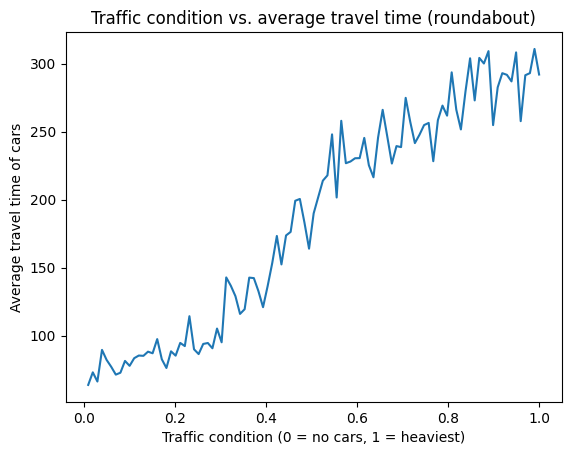

In [ ]:
# task 8: plotting average travel time vs. traffic flow, roundabout version
traffic_flow_range = np.linspace(0, 1, 100)
travel_time_averages_r = []
for tf in traffic_flow_range:
  # perform simulation
  cars = roundabout_simulation(tf)
  # obtain average travel time
  travel_times = []
  for c in cars:
    travel_times.append(c._travel_time)
  travel_time_averages_r.append(np.mean(travel_times))
# plotting
plt.plot(traffic_flow_range, travel_time_averages_r)
plt.title("Traffic condition vs. average travel time (roundabout)")
plt.xlabel("Traffic condition (0 = no cars, 1 = heaviest)")
plt.ylabel("Average travel time of cars")

In [ ]:
# task 9: implementing assymetric traffic and calculating average travel time for
# heavy and light traffic roads separately, roundabout
cars, heavy, light = roundabout_simulation(0.5, skewed=True, skewness=0.7)

# find average travel time for heavy traffic cars
travel_times_heavy_r = []
for c in heavy:
  travel_times_heavy_r.append(c._travel_time)
print("The average time for a car to pass the intersection when coming from a heavier-traffic road is: {0} frames".format(np.mean(travel_times_heavy_r)))

# find average travel time for light traffic cars
travel_times_light_r = []
for c in light:
  travel_times_light_r.append(c._travel_time)
print("The average time for a car to pass the intersection when coming from a lighter-traffic road is: {0} frames".format(np.mean(travel_times_light_r)))

The average time for a car to pass the intersection when coming from a heavier-traffic road is: 147.20289855072463 frames
The average time for a car to pass the intersection when coming from a lighter-traffic road is: 209.09677419354838 frames


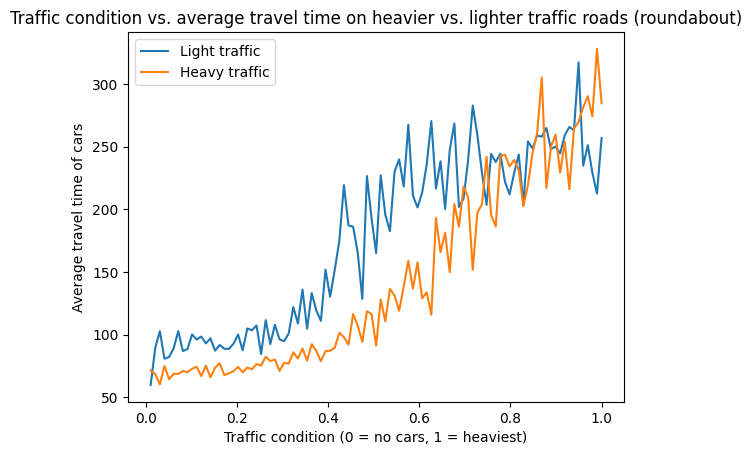

In [ ]:
# task 10: implementing assymetric traffic and calculating average travel time vs.
# traffic conditions for light and heavy traffic cars separately, for roundabout
traffic_flow_range = np.linspace(0, 1, 100)

# store heavy and light traffic averages separately
travel_time_averages_heavy_r = []
travel_time_averages_light_r = []
for tf in traffic_flow_range:
  # perform simulation
  cars, heavy, light = roundabout_simulation(tf, skewed=True, skewness=0.7)
  # obtain average travel time for heavy traffic
  travel_times = []
  for c_h in heavy:
    travel_times.append(c_h._travel_time)
  travel_time_averages_heavy_r.append(np.mean(travel_times))
  # obtain average travel time for light traffic
  travel_times = []
  for c_l in light:
    travel_times.append(c_l._travel_time)
  travel_time_averages_light_r.append(np.mean(travel_times))

# plotting heavy traffic averages
plt.figure()
plt.plot(traffic_flow_range, travel_time_averages_light_r, label="Light traffic")
plt.plot(traffic_flow_range, travel_time_averages_heavy_r, label="Heavy traffic")
plt.title("Traffic condition vs. average travel time on heavier vs. lighter traffic roads (roundabout)")
plt.xlabel("Traffic condition (0 = no cars, 1 = heaviest)")
plt.ylabel("Average travel time of cars")
plt.legend()

Text(0, 0.5, 'Average travel time of cars')

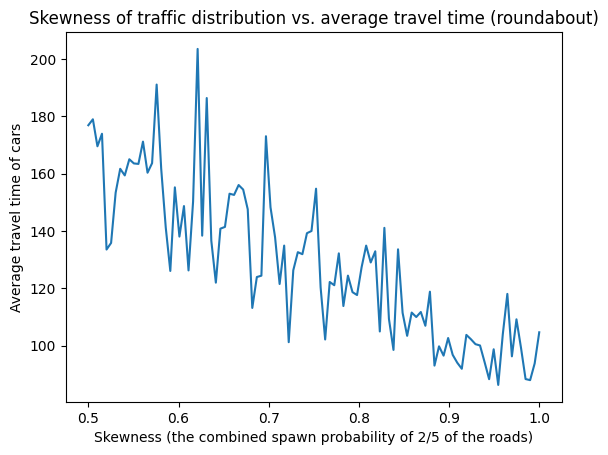

In [ ]:
# task 11: keeping the traffic condition fixed and increasing skewness to see how
# it affects the overall average travel time, roundabout

skewness_range = np.linspace(0.5, 1, 100)

travel_time_averages_skew_r = []
for sk in skewness_range:
  # perform simulation
  cars, heavy, light = roundabout_simulation(0.5, skewed=True, skewness=sk)
  # obtain average travel time
  travel_times = []
  for c in cars:
    travel_times.append(c._travel_time)
  travel_time_averages_skew_r.append(np.mean(travel_times))

# plotting heavy traffic averages
plt.figure()
plt.plot(skewness_range, travel_time_averages_skew_r)
plt.title("Skewness of traffic distribution vs. average travel time (roundabout)")
plt.xlabel("Skewness (the combined spawn probability of 2/5 of the roads)")
plt.ylabel("Average travel time of cars")

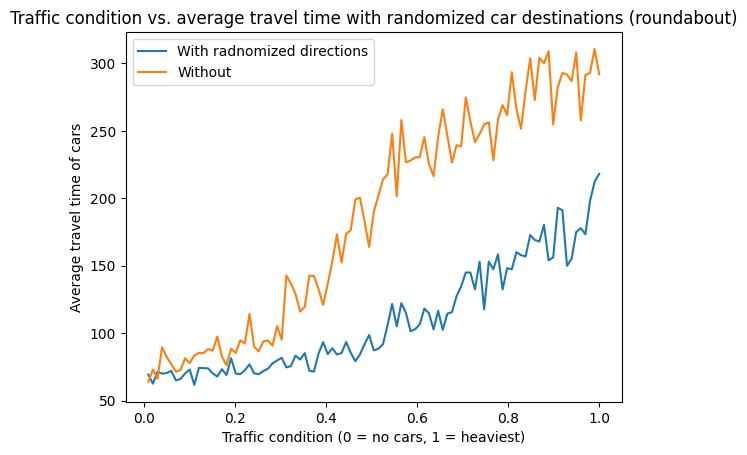

In [ ]:
# task 12: investigating average travel time vs. traffic condition for
# a randomized-destination simulation
traffic_flow_range = np.linspace(0, 1, 100)
travel_time_averages_multi_r = []
for tf in traffic_flow_range:
  # perform simulation
  cars = roundabout_simulation(tf, multidirection=True)
  # obtain average travel time
  travel_times = []
  for c in cars:
    travel_times.append(c._travel_time)
  travel_time_averages_multi_r.append(np.mean(travel_times))
# plotting
plt.plot(traffic_flow_range, travel_time_averages_multi_r, label="With radnomized directions")
plt.plot(traffic_flow_range, travel_time_averages_r, label="Without")
plt.title("Traffic condition vs. average travel time with randomized car destinations (roundabout)")
plt.xlabel("Traffic condition (0 = no cars, 1 = heaviest)")
plt.ylabel("Average travel time of cars")
plt.legend()